# Task 7: Building the Best Model
In this task, we build a model to classify the EEG data into their respective classes. Through testing, we have concluded that the best model for this use case would be a 1D Convolutional Neural Network. It's implementation is explained in detail below.
## 1. Importing Libraries

The necessary libraries are imported to handle data processing, model training, and evaluation:
```python
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
```

---

## 2. Utility Functions

### 2.1 Set Random Seed for Reproducibility
To ensure that the model results are reproducible, a function to set a fixed random seed is defined:
```python
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
```

### 2.2 Define Paths and Class Mappings
Paths to the dataset and a dictionary for class mappings are defined for efficient data loading:
```python
base_path = "/kaggle/input/impulse/Impulse/EEG_Data"
train_path = os.path.join(base_path, "train_data")
val_path = os.path.join(base_path, "validation_data")
test_path = os.path.join(base_path, "test_data")

class_mapping = {
    "Complex_Partial_Seizures": 1,
    "Electrographic_Seizures": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3,
    "Normal": 0
}
```

---

## 3. Data Loading Functions

### 3.1 Load Labeled Data
This function loads labeled data by reading `.npy` files from the dataset:
```python
def load_labeled_data(data_path, class_mapping):
    """Load labeled data from the given path."""
    data, labels = [], []
    for class_name, label in class_mapping.items():
        class_folder = os.path.join(data_path, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.endswith(".npy"):
                    sample = np.load(os.path.join(class_folder, file))
                    data.append(sample)
                    labels.append(label)
    return np.array(data), np.array(labels)
```

### 3.2 Load Unlabeled Data
This function loads unlabeled data for the test set:
```python
def load_unlabeled_data(data_path):
    """Load unlabeled data from the given path."""
    data, filenames = [], []
    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            sample = np.load(os.path.join(data_path, file))
            data.append(sample)
            filenames.append(file)
    return np.array(data), filenames
```

---

## 4. Normalizing Data
The EEG data is normalized to have zero mean and unit variance to ensure stable training:
```python
def normalize_data(data):
    """Normalize the EEG data."""
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return ((data - mean) / std).astype(np.float32)
```

---

## 5. Dataset Class for EEG Data

### 5.1 EEG Dataset Class
A custom `Dataset` class is defined to handle EEG data and augmentation:
```python
class EEGDataset1D(Dataset):
    """Custom dataset for EEG data."""
    def __init__(self, data, labels=None, augment=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        print(f"Permuted data shape: {self.data.shape}")  # Debug: Confirm shape
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.augment = augment # Augmentation flag

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        # Retrieve sample and (optionally) add noise
        sample = self.data[idx]
        if self.augment:
            sample = self.add_noise(sample.numpy())
        if self.labels is not None:
            return sample, self.labels[idx]  # Return sample with label
        return sample  # Return only sample for test data

    def add_noise(self, sample, noise_level=0.05):
        """Add Gaussian noise for data augmentation."""
        noise = np.random.randn(*sample.shape) * noise_level
        return torch.tensor(sample + noise, dtype=torch.float32)
```

---

## 6. DataLoader for Training, Validation, and Testing

The data is split into training, validation, and test sets, with DataLoader used for batch processing:
```python
train_dataset = EEGDataset1D(train_data, train_labels, augment=True)
val_dataset = EEGDataset1D(val_data, val_labels)
test_dataset = EEGDataset1D(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
```

---

## 7. Model Definition

### 7.1 Weight Initialization
A function is defined to initialize model weights using Xavier initialization:
```python
def initialize_weights(module):
    """Initialize weights for layers."""
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
```

### 7.2 Define the 1D CNN Model
A simple 1D CNN model is defined to process EEG signals and classify them into categories:
```python
class Simple1DCNN(nn.Module):
    """Simple 1D CNN model for EEG classification."""
    def __init__(self, input_channels, input_length, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # Determine flattened size for fully connected layers
        dummy_input = torch.zeros(1, input_channels, input_length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

        self.apply(initialize_weights)

    def _get_flattened_size(self, x):
        """Calculate the size of the flattened feature map after convolution and pooling."""
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        """Forward pass through the network."""
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
```

---

## 8. Model Setup

### 8.1 Class Weights
Class weights are computed to handle class imbalances during training:
```python
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
```

### 8.2 Loss and Optimizer
The loss function and optimizer are defined for model training:
```python
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
```

---

## 9. Training the Model

### 9.1 Training Function
The training function trains the model over multiple epochs and handles early stopping:
```python
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=7):
    """Train the model."""
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_weights.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_weights.pth"))
    return model

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)
```

---

## 10. Evaluating the Model

### 10.1 Evaluation Function
The model's performance is evaluated using accuracy, classification report, confusion matrix, and ROC AUC score:
```python
def evaluate_model(model, val_loader, class_names):
    """Evaluate model performance on validation data."""
    model.eval()
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(1).cpu().numpy()

            val_preds.extend(preds)
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Validation Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # Balanced Accuracy Score
    balanced_acc = balanced_accuracy_score(val_labels, val_preds)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

    # ROC AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
        print(f"ROC AUC Score (OvR): {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC Score could not be computed (ensure probabilities are provided and labels are multi-class).")

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Normal", "Complex Partial Seizures", "Electrographic Seizures", "Video-detected Seizures"]
evaluate_model(trained_model, val_loader, class_names)
```

---

## 11. Making Test Predictions

### 11.1 Prediction Function
The model generates predictions on the test set, which are saved to a CSV file:
```python
def generate_test_predictions(model, test_loader):
    """Generate predictions on the test set."""
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = outputs.argmax(1).cpu().numpy()
            predictions.extend(preds)
    return predictions

test_predictions = generate_test_predictions(trained_model, test_loader)

def save_sorted_predictions(filenames, predictions, output_file="test_predictions_cnn1d_best1.csv"):
    """Save predictions to a CSV file."""
    results = pd.DataFrame({"Filename": filenames, "Predicted Label": predictions})
    results["Numeric Order"] = results["Filename"].str.extract(r'(\d+)').astype(int)
    results = results.sort_values(by="Numeric Order").drop(columns=["Numeric Order"])
    results.to_csv(output_file, index=False)
    print(f"Test predictions saved to {output_file}")

save_sorted_predictions(test_filenames, test_predictions)
```

---

Overall, the 1DCNN model achieved an average f1 score of 0.92, a balanced accuracy score of 0.9552 and a ROC AUC score of 0.9888 on the validation data. After testing and trying out several models, this is the best result we have achieved in classifying the data.



# Importing libaries

In [34]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd



# 1. Utility Functions


In [35]:
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Paths
base_path = "/kaggle/input/impulse/Impulse/EEG_Data"
train_path = os.path.join(base_path, "train_data")
val_path = os.path.join(base_path, "validation_data")
test_path = os.path.join(base_path, "test_data")

class_mapping = {
    "Complex_Partial_Seizures": 1,
    "Electrographic_Seizures": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3,
    "Normal": 0
}

def load_labeled_data(data_path, class_mapping):
    data, labels = [], []
    for class_name, label in class_mapping.items():
        class_folder = os.path.join(data_path, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.endswith(".npy"):
                    sample = np.load(os.path.join(class_folder, file))
                    data.append(sample)
                    labels.append(label)
    return np.array(data), np.array(labels)

def load_unlabeled_data(data_path):
    data, filenames = [], []
    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            sample = np.load(os.path.join(data_path, file))
            data.append(sample)
            filenames.append(file)
    return np.array(data), filenames

# 2. Data Loading

In [36]:
# Data Loading
train_data, train_labels = load_labeled_data(train_path, class_mapping)
val_data, val_labels = load_labeled_data(val_path, class_mapping)
test_data, test_filenames = load_unlabeled_data(test_path)

In [37]:
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return ((data - mean) / std).astype(np.float32)

train_data = normalize_data(train_data)
val_data = normalize_data(val_data)
test_data = normalize_data(test_data)

In [38]:
class EEGDataset1D(Dataset):
    def __init__(self, data, labels=None, augment=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        print(f"Permuted data shape: {self.data.shape}")  # Debug: Confirm shape
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.augment = augment # Augmentation flag

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        # Retrieve sample and (optionally) add noise
        sample = self.data[idx]
        if self.augment:
            sample = self.add_noise(sample.numpy())
        if self.labels is not None:
            return sample, self.labels[idx]  # Return sample with label
        return sample  # Return only sample for test data

    def add_noise(self, sample, noise_level=0.05):
        # Add Gaussian noise for augmentation
        noise = np.random.randn(*sample.shape) * noise_level
        return torch.tensor(sample + noise, dtype=torch.float32)





In [39]:
train_dataset = EEGDataset1D(train_data, train_labels, augment=True)
val_dataset = EEGDataset1D(val_data, val_labels)
test_dataset = EEGDataset1D(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


Permuted data shape: torch.Size([5608, 19, 500])
Permuted data shape: torch.Size([1403, 19, 500])
Permuted data shape: torch.Size([779, 19, 500])


# 3. Model definition

In [40]:
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [41]:

class Simple1DCNN(nn.Module):
    def __init__(self, input_channels, input_length, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        dummy_input = torch.zeros(1, input_channels, input_length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

        self.apply(initialize_weights)

    def _get_flattened_size(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [42]:
input_channels = train_data.shape[1]  # Features dimension (19)
input_length = train_data.shape[2]    # Sequence length (500)
num_classes = len(class_mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_channels, input_length, num_classes).to(device)


In [43]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)



In [44]:
for batch in train_loader:
    data, labels = batch
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break


Data shape: torch.Size([32, 19, 500]), Labels shape: torch.Size([32])


# 4. Training the model

In [45]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=7):
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_weights.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_weights.pth"))
    return model

In [46]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)


Epoch 1/30, Train Loss: 371.9397, Train Acc: 0.5619, Val Loss: 24.3316, Val Acc: 0.8019
Epoch 2/30, Train Loss: 213.0859, Train Acc: 0.6730, Val Loss: 23.8647, Val Acc: 0.8182
Epoch 3/30, Train Loss: 147.4808, Train Acc: 0.7234, Val Loss: 22.7849, Val Acc: 0.8118
Epoch 4/30, Train Loss: 100.2861, Train Acc: 0.7691, Val Loss: 21.2744, Val Acc: 0.8297
Epoch 5/30, Train Loss: 89.3239, Train Acc: 0.7921, Val Loss: 19.8942, Val Acc: 0.8418
Epoch 6/30, Train Loss: 81.5043, Train Acc: 0.8056, Val Loss: 16.2109, Val Acc: 0.8617
Epoch 7/30, Train Loss: 76.2248, Train Acc: 0.8087, Val Loss: 15.8305, Val Acc: 0.8774
Epoch 8/30, Train Loss: 63.7243, Train Acc: 0.8374, Val Loss: 17.9430, Val Acc: 0.8517
Epoch 9/30, Train Loss: 61.9043, Train Acc: 0.8333, Val Loss: 14.7126, Val Acc: 0.8639
Epoch 10/30, Train Loss: 52.3139, Train Acc: 0.8541, Val Loss: 14.3030, Val Acc: 0.8653
Epoch 11/30, Train Loss: 55.7988, Train Acc: 0.8588, Val Loss: 14.8609, Val Acc: 0.8667
Epoch 12/30, Train Loss: 61.7710, Tra

<ipython-input-45-b673d6e798c5>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_weights.pth"))


# 5. Evaluating the model

Validation Classification Report:
                          precision    recall  f1-score   support

                  Normal       0.92      0.93      0.92       696
Complex Partial Seizures       0.93      0.89      0.91       549
 Electrographic Seizures       0.89      1.00      0.94       137
 Video-detected Seizures       1.00      1.00      1.00        21

                accuracy                           0.92      1403
               macro avg       0.94      0.96      0.94      1403
            weighted avg       0.92      0.92      0.92      1403

Balanced Accuracy Score: 0.9552
ROC AUC Score (OvR): 0.9888


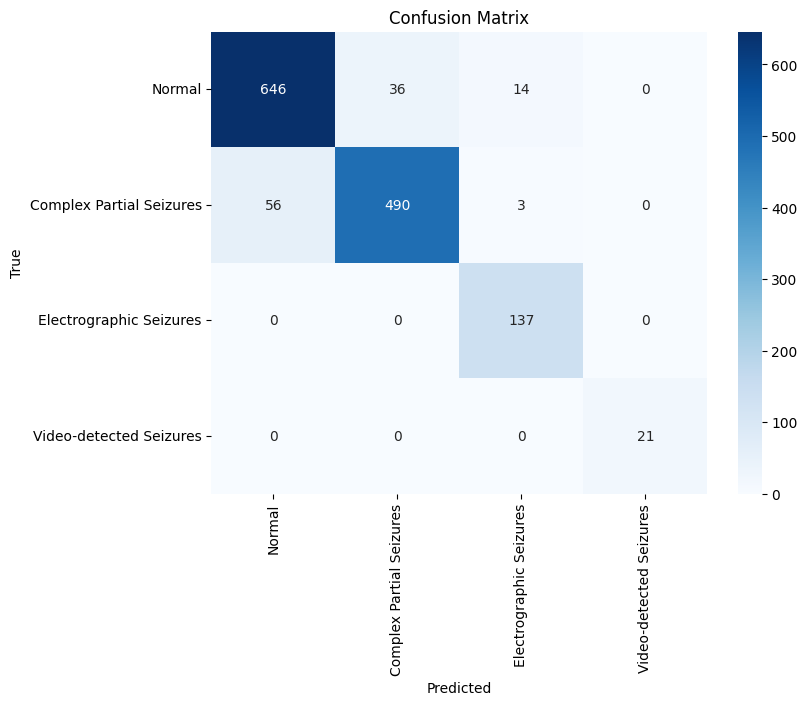

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, val_loader, class_names):
    model.eval()
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(1).cpu().numpy()

            val_preds.extend(preds)
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Validation Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # Balanced Accuracy Score
    balanced_acc = balanced_accuracy_score(val_labels, val_preds)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

    # ROC AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
        print(f"ROC AUC Score (OvR): {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC Score could not be computed (ensure probabilities are provided and labels are multi-class).")

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Normal", "Complex Partial Seizures", "Electrographic Seizures", "Video-detected Seizures"]
evaluate_model(trained_model, val_loader, class_names)


# 6. Making Test Predictions

In [50]:
def generate_test_predictions(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = outputs.argmax(1).cpu().numpy()
            predictions.extend(preds)
    return predictions

test_predictions = generate_test_predictions(trained_model, test_loader)

def save_sorted_predictions(filenames, predictions, output_file="test_predictions_cnn1d_best1.csv"):
    results = pd.DataFrame({"Filename": filenames, "Predicted Label": predictions})
    results["Numeric Order"] = results["Filename"].str.extract(r'(\d+)').astype(int)
    results = results.sort_values(by="Numeric Order").drop(columns=["Numeric Order"])
    results.to_csv(output_file, index=False)
    print(f"Test predictions saved to {output_file}")

save_sorted_predictions(test_filenames, test_predictions)

Test predictions saved to test_predictions_cnn1d_best1.csv
